# Test tiger with simple linear regression

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

# Set path such that interpreter finds tigerpy
import sys
sys.path.append("..")

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd

rng = np.random.default_rng(42)

## Simulate data

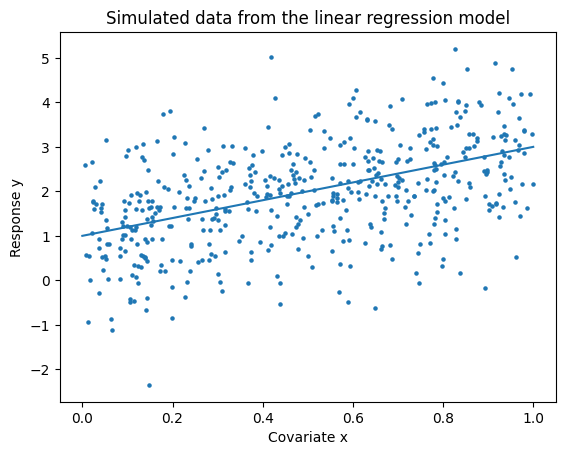

In [2]:
# Sample size and true parameters

n = 500
true_beta = np.array([1.0, 2.0])
true_sigma = 1.0

# Data-generating process

x0 = rng.uniform(size=n)
X_mat = np.column_stack([np.ones(n), x0])
eps = rng.normal(scale=true_sigma, size=n)
response_vec = X_mat @ true_beta + eps

# Data to plot the linear regression line
x_plot = np.linspace(0, 1, num=200)
X_plot = np.column_stack([np.ones(200), x_plot])

# Plot the simulated data
plt.scatter(x0, response_vec, s = 5)
plt.plot(x_plot, X_plot @ true_beta)
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()

## Set up model in tigerpy

In [3]:
# Set up design matrix 
X = tiger.Obs(name="X_loc")
X.fixed(data = x0)

# Set up hyperparameters
beta_loc = tiger.Hyper(0.0, name="beta_loc")
beta_scale = tiger.Hyper(100.0, name="beta_scale")

# Set up parameters
beta_dist = tiger.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = tiger.Param(value=np.array([0.0, 0.0]), distribution=beta_dist, name="beta")

# Set up hyperparameters for the scale
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)

# Use paramter param_space="positive" to transform sigma into unconstrained space  
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta=beta)

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=response_vec, distribution=response_dist)

In [4]:
jnp.sum(m.log_lik)

Array(-1623.414, dtype=float32)

In [5]:
m.log_prior

Array(-18.020359, dtype=float32)

In [6]:
m.log_prob

Array(-1641.4343, dtype=float32)

In [7]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

In [8]:
graph.logprob()

Array([-1641.4343], dtype=float32)

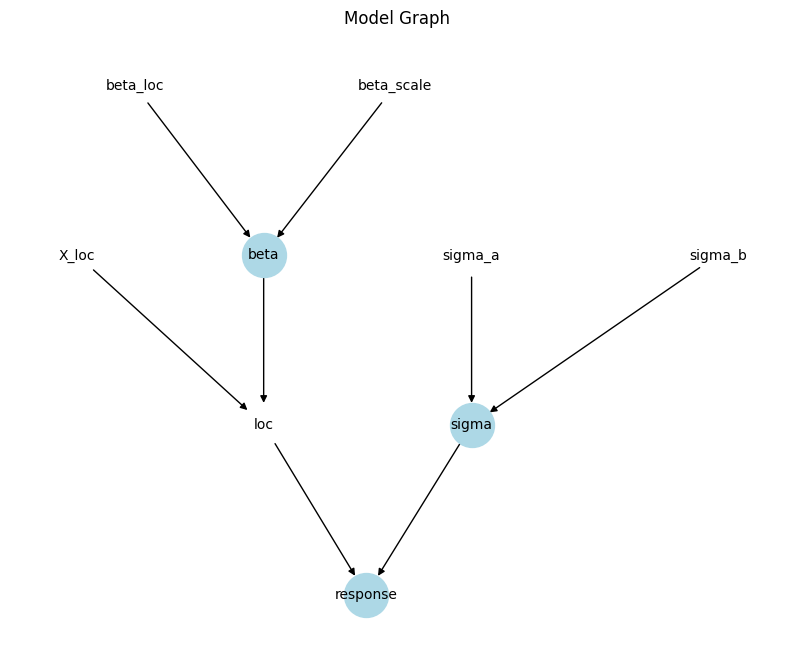

In [9]:
graph.visualize_graph()

## Inference with BBVI

### Test 

In [10]:
import tigerpy.distributions.mvn as mvn

In [11]:
q = bbvi.Bbvi_bayes_lm(graph=graph)

In [12]:
q.hyperparams

{'beta': {'beta_loc': Array(0., dtype=float32, weak_type=True),
  'beta_scale': Array(100., dtype=float32, weak_type=True)},
 'sigma': {'sigma_a': Array(0.01, dtype=float32, weak_type=True),
  'sigma_b': Array(0.01, dtype=float32, weak_type=True)}}

In [13]:
q.init_variational_params

{'beta': {'loc': Array([0., 0.], dtype=float32),
  'lower_tri': Array([[1., 0.],
         [0., 1.]], dtype=float32)},
 'sigma': {'loc': Array([2.3025851], dtype=float32, weak_type=True),
  'lower_tri': Array([[1.]], dtype=float32)}}

In [14]:
key = jax.random.PRNGKey(27)

In [15]:
loc_beta, lower_tri_beta = q.init_variational_params["beta"]["loc"], q.init_variational_params["beta"]["lower_tri"]
loc_sigma, lower_tri_sigma = q.init_variational_params["sigma"]["loc"], q.init_variational_params["sigma"]["lower_tri"]

In [16]:
samples_beta = mvn.mvn_precision_chol_sample(loc=loc_beta, precision_matrix_chol=lower_tri_beta, key=key, S=64)
samples_sigma = mvn.mvn_precision_chol_sample(loc=loc_sigma, precision_matrix_chol=lower_tri_sigma, key=key, S=64)

In [17]:
test_samples = {"beta": samples_beta, "sigma": jnp.exp(samples_sigma)}

In [18]:
attr = q.digraph.nodes["response"]["attr"]

In [19]:
batch_idx = jax.random.choice(key, 500, (32,), replace=False)

In [20]:
data_new = jax.tree_map(lambda x: x[batch_idx], q.data)

In [21]:
-1639.2402

-1639.2402

In [22]:
bbvi.Bbvi_bayes_lm.mc_logprob(data_new, q.hyperparams,  test_samples, q.num_obs)

Array(-1639.2402, dtype=float32)

In [23]:
2516.9612

2516.9612

In [25]:
q.lower_bound(q.init_variational_params, 
              data_new,
              q.hyperparams,
              num_var_samples=64,
              num_obs=q.num_obs,
              key=key)

Array(2516.9612, dtype=float32)

## Run bbvi

In [10]:
q = bbvi.Bbvi_bayes_lm(graph=graph)

In [11]:
q.run_bbvi(step_size=0.01,
            threshold=1e-2,
            key_int=27,
            batch_size=128,
            num_var_samples=64,
            chunk_size=50,
            epochs=5000)

(Array(-727.2999, dtype=float32),
 {'beta': {'loc': Array([0.9834803, 1.9164865], dtype=float32),
   'cov': Array([[ 0.00860037, -0.01304328],
          [-0.01304328,  0.02610551]], dtype=float32)},
  'sigma': {'loc': Array([0.01198567], dtype=float32),
   'cov': Array([[0.0013826]], dtype=float32)}})

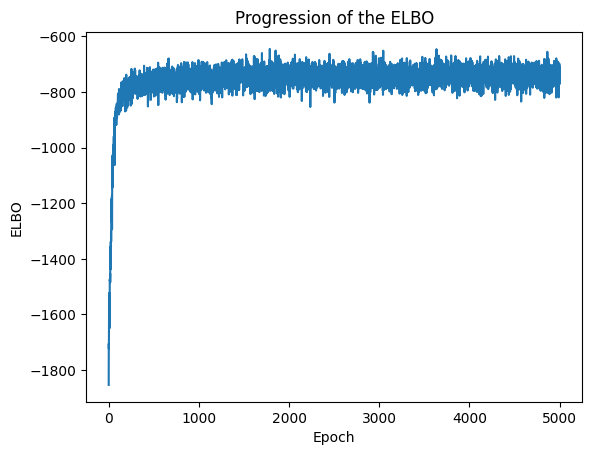

In [12]:
q.plot_elbo()

In [16]:
# plot the regression line 
b = q.opt_variational_params["beta"]["loc"]
x_new = jnp.linspace(x0.min(), x0.max(), num=100)
X_new = tiger.Obs(name="X_pred")
X_new.fixed(data = x_new)
y = X.design_matrix @ b

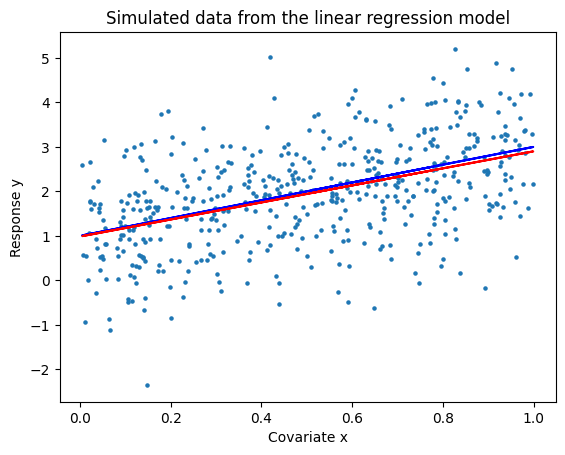

In [17]:
# plot the data
fig, ax = plt.subplots()

plt.scatter(x0, response_vec, s = 5)
plt.plot(x0, X_mat @ true_beta, color ="b")
plt.plot(x0, y, color = "r")
plt.title("Simulated data from the linear regression model")
plt.xlabel("Covariate x")
plt.ylabel("Response y")
plt.show()